In [1]:
import csv
import pandas as pd

import os
import sys

module_path = os.path.abspath(os.path.join('../../..'))
if module_path not in sys.path:
    sys.path.append(module_path)

%load_ext autoreload
%autoreload 2
    
from experiments.pretraining_vs_finetuning.finetuning_volume.volume_buckets import finetuning_proportion_buckets

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 250/250 [00:00<00:00, 15945.74it/s]


Text(0, 0.5, 'Corrected P(STAY)')

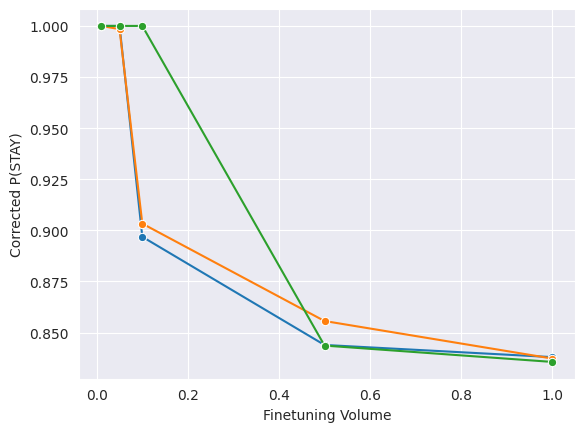

In [15]:
import seaborn as sns
sns.set_style('darkgrid')
import matplotlib.pyplot as plt

def plot_finetuning_trend(dataset):
    x = []
    y = []
    
    for prop, datasets in finetuning_proportion_buckets.items():
    
        summary = datasets[f'{dataset}-human'].linguistic_robustness_summary(datasets[f'{dataset}-test'])
        
        acc = summary['paraphrase_accuracy_corrected'] #datasets[f'{dataset}-test'].accuracy
        p_stay_c = summary['stay_prob_corrected']
        
        x.append(prop)
        y.append(p_stay_c)
    
    
    sns.lineplot(x=x, y=y, marker='o')
    # for i, words in enumerate(list(finetuning_proportion_buckets.keys())):
    #     plt.text(x[i]+0.01, y[i]-0.01, words, fontsize=10, ha='center', va='center', color='black')

plot_finetuning_trend('snli')
plot_finetuning_trend('atomic')
plot_finetuning_trend('social')

ax = plt.gca()
ax.set_xlabel("Finetuning Volume")
ax.set_ylabel("Corrected P(STAY)")